In [226]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

pd.set_option('display.max_columns', 32)

## **Load Dataset**

* In this exam, we only use 3000 rows

In [227]:
# index 0 - 3000
df = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv', nrows=3000)

print('DataFrame shape:', df.shape)

DataFrame shape: (3000, 32)


In [228]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## **Data Cleaning & Preprocessing**

* There are 3 features NULL values
* i think they don't have a strong relationship with target, so i won't use this features for prediction

In [229]:
null_features = df.columns[df.isna().any()]

null_df = df[null_features].isna().sum().rename('Total Missing Values').to_frame()
null_df['percentage'] = round(null_df['Total Missing Values'] / df.shape[0] * 100, 2)

null_df.sort_values('percentage', ascending=False)

,Total Missing Values,percentage
company,2877,95.90
agent,465,15.50
country,1,0.03


Since duplicate rows can bias prediction, i decided to remove them

In [230]:
print('Duplicated rows in DataFrame:', df.duplicated().sum())

df.drop_duplicates(inplace=True)

Duplicated rows in DataFrame: 308


## Feature extraction

* More features are used, the more likely our model will overfitting to training data
* So i used feature extraction for reduce the number of features

In [231]:
def family(dataset):
    if (dataset['adults'] > 0) & (dataset['children'] > 0):
        return 1
    elif (dataset['adults'] > 0) & (dataset['babies'] > 0):
        return 1
    else:
        return 0
    
df['is_family'] = df.apply(family, axis=1)

In [232]:
df['total_nights'] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

## **EDA**

Before choose which features are use for prediction, let's do EDA first for better understanding about those features

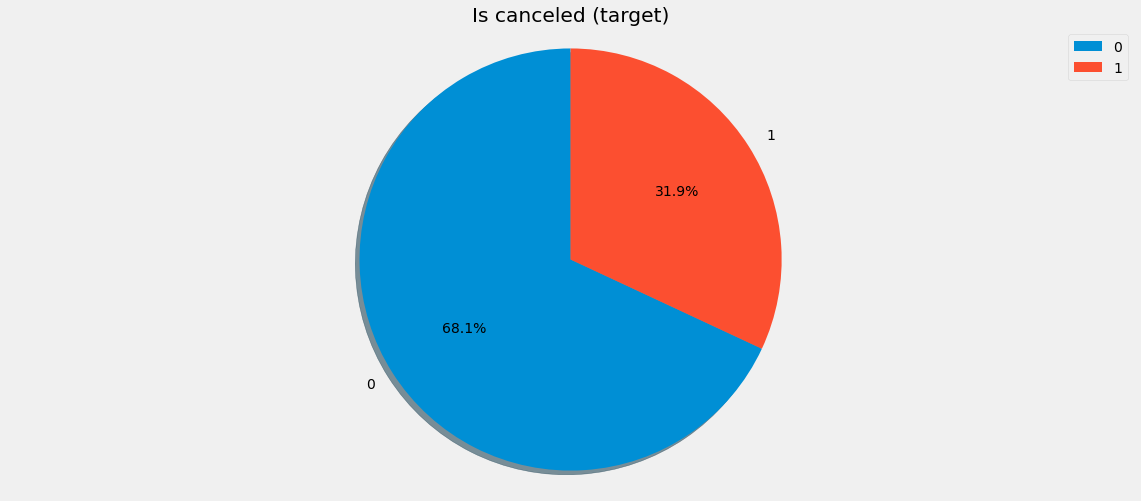

In [233]:
is_canceled = df['is_canceled'].value_counts()

plt.pie(is_canceled.values,
        labels=is_canceled.index,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.title('Is canceled (target)')
plt.legend()
plt.axis('equal')
plt.show()

1. Usually cancelation rate is low in (healthy) hotel booking demand
1. Let's find out what causes cancelation rate becane quite high?

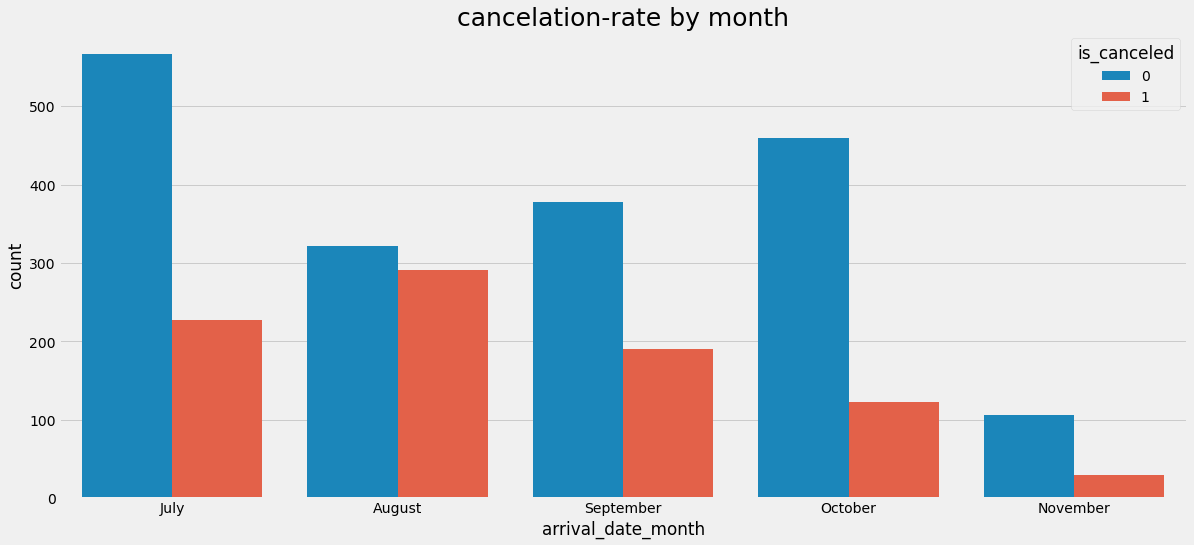

In [234]:
arrival_month = df.arrival_date_month.value_counts()

sns.countplot(x='arrival_date_month',
            hue='is_canceled',
            data=df).set_title('cancelation-rate by month', fontsize=25);

* Most users canceled their hotel-booking on August
* Cancelation-rate on September also quite high

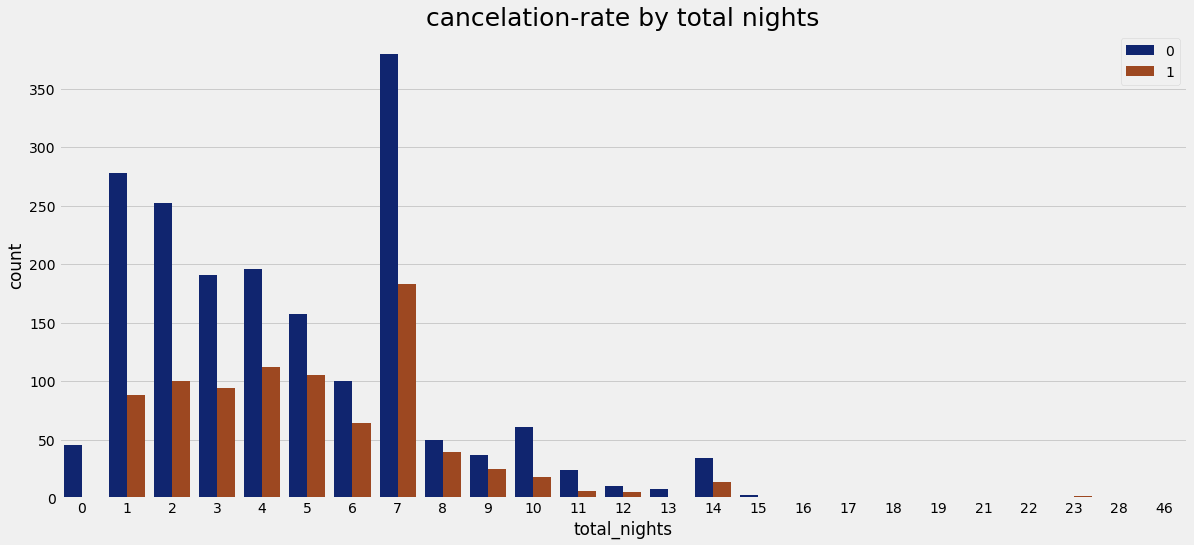

In [235]:
sns.countplot(x='total_nights',
            hue='is_canceled',
            data=df,
            palette='dark').set_title('cancelation-rate by total nights', fontsize=25)

plt.legend(loc=1);

* From total nights 1 to 6 days, also 8 or 9 days, we can see..
* the longer users want to stay, the greater probability the users will cancel their booking

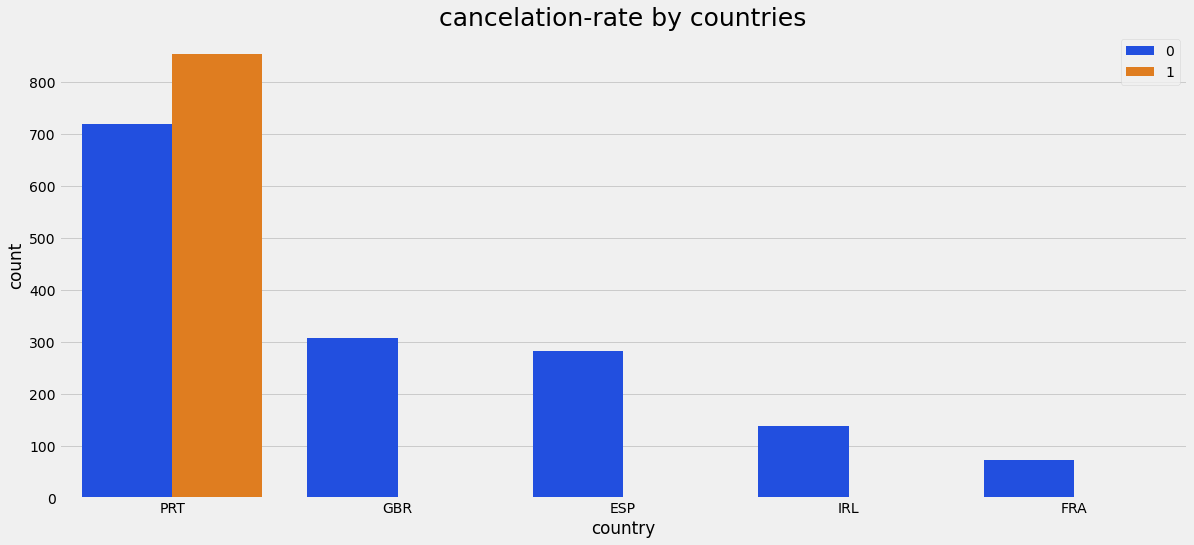

In [236]:
top_6_counties = (df['country'] == 'PRT') | (df['country'] == 'GBR') | (df['country'] == 'ESP') | (df['country'] == 'IRL') | (df['country'] == 'FRA')

df_top_6_countries = df[top_6_counties]

sns.countplot(x='country',
            hue='is_canceled',
            data=df_top_6_countries,
            palette='bright').set_title('cancelation-rate by countries', fontsize=25)

plt.legend(loc=1);

* PRT is Portugal, do you remember Cristiano Ronaldo :)
* Interesting, cancelation-rate is very high for Portugal users, even their possibilities for canceled is higher than no-cancel
* So i'll make new features for give a flag, is this user Portuguese? (sorry, no racism, just coincidentally the dataset is like this)

In [237]:
df['is_portuguese'] = df['country'].apply(lambda x: 1 if x == 'PRT' else 0)

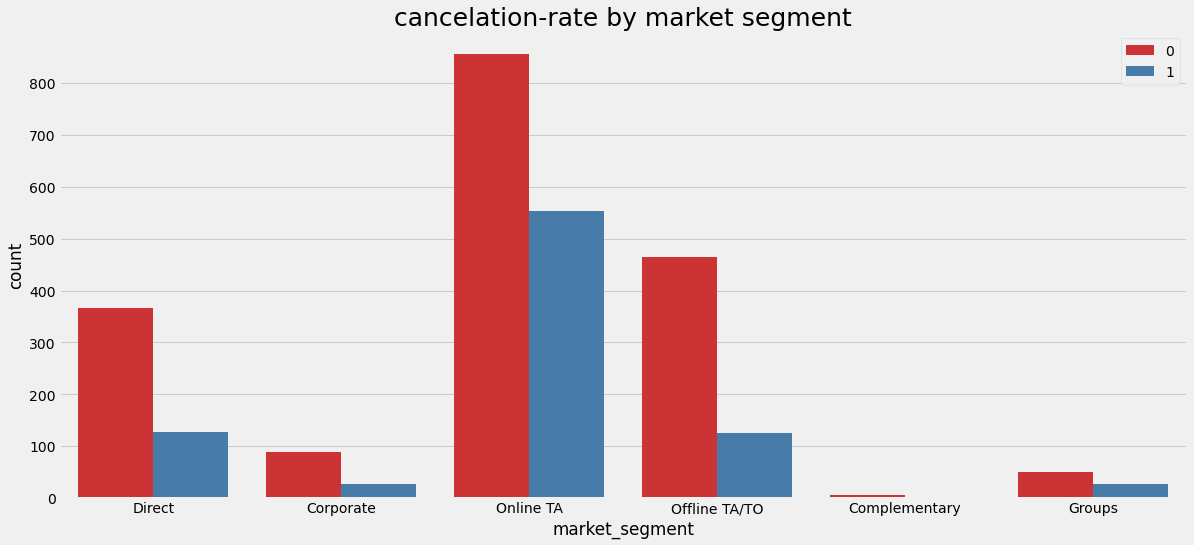

In [238]:
sns.countplot(x='market_segment',
            hue='is_canceled',
            data=df,
            palette='Set1').set_title('cancelation-rate by market segment', fontsize=25)

plt.legend(loc=1);

* If the market segment is Online, the possibility of canceling is higher than others

### How much do guests pay for a room per night?

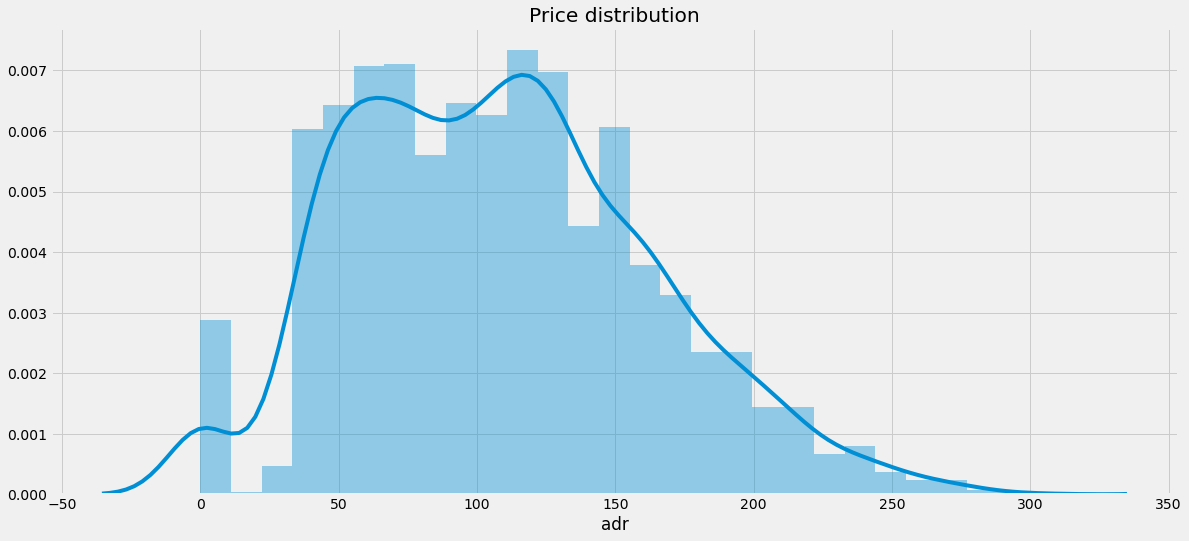

In [239]:
sns.distplot(df['adr']).set_title('Price distribution');

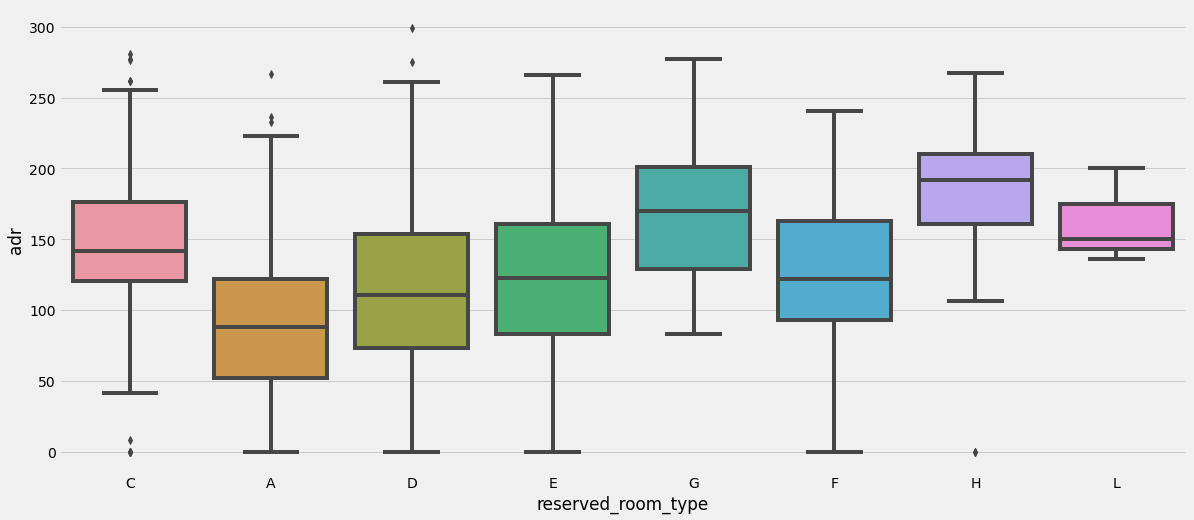

In [240]:
sns.boxplot(x=df['reserved_room_type'],
            y=df['adr']);

* adr features: hotel price
* reserved_room_type features: which room type the users booked?
* Room G has a highest price

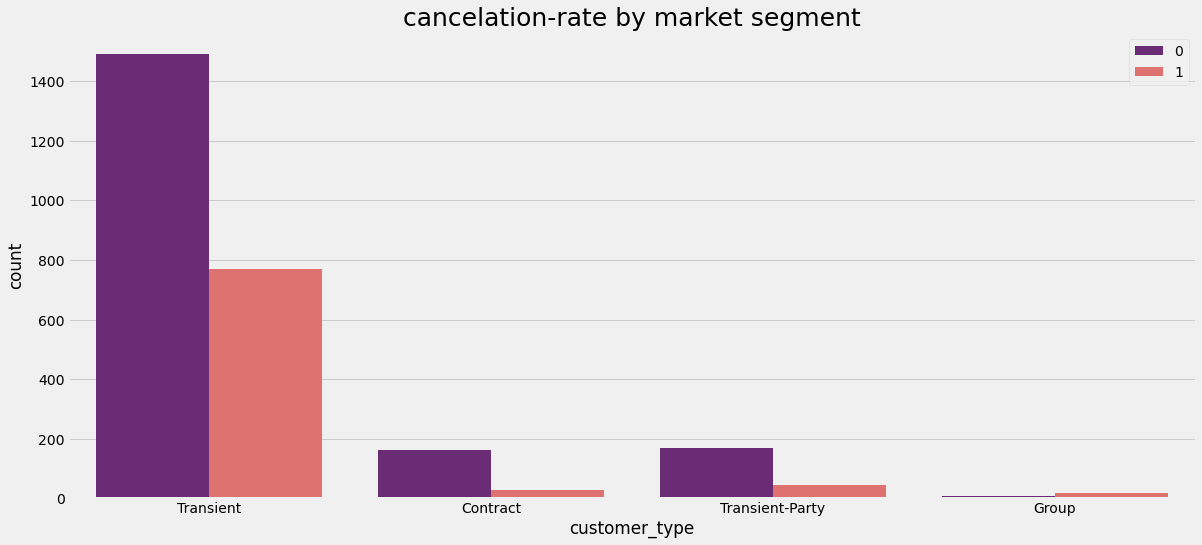

In [241]:
sns.countplot(x='customer_type',
            hue='is_canceled',
            data=df,
            palette='magma').set_title('cancelation-rate by market segment', fontsize=25)

plt.legend(loc=1);

* The possibility of canceling is higher if customer type is Group
* Transient also quite high

### After EDA & analyze, i choosed this features for build a model

* arrival_date_month
* total_nights
* is_portuguese
* market_segment
* customer_type
* is_canceled (target)

In [242]:
final_df = df[['arrival_date_month', 'total_nights', 'is_portuguese', 'market_segment', 'customer_type', 'is_canceled']]

In [243]:
final_df = pd.get_dummies(final_df, columns=['arrival_date_month', 'market_segment', 'customer_type'])

final_df.head()

,total_nights,is_portuguese,is_canceled,arrival_date_month_August,arrival_date_month_July,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
4,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


## Model Building & Hyper-parameter Tuning

In [244]:
X = final_df.drop('is_canceled', axis=1)
y = final_df['is_canceled']

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=2020)

In [263]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report

In [258]:
from scipy.stats import randint

param_dist = {"max_depth": [3, 5, 7],
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

tree_cv = RandomizedSearchCV(rf, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0629b2fb10>})

In [260]:
# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}
Best score is 0.8035407111638697


### Final Tuning

* Random Forest is FOREST, so we have to use a lot of tree, i choosed 7000 tree
* I decided to not follow RandomizedSearchCV and tuning by manual

In [269]:
rf = RandomForestClassifier(max_depth=7, n_estimators=7000, n_jobs=-1, random_state=2020)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=7000, n_jobs=-1,
                       random_state=2020)

In [270]:
cv_score = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=10)
print('Cross Validation Score:', cv_score.mean())

Cross Validation Score: 0.8160788113695091


In [271]:
y_pred = rf.predict(X_test)

## Model Evaluation

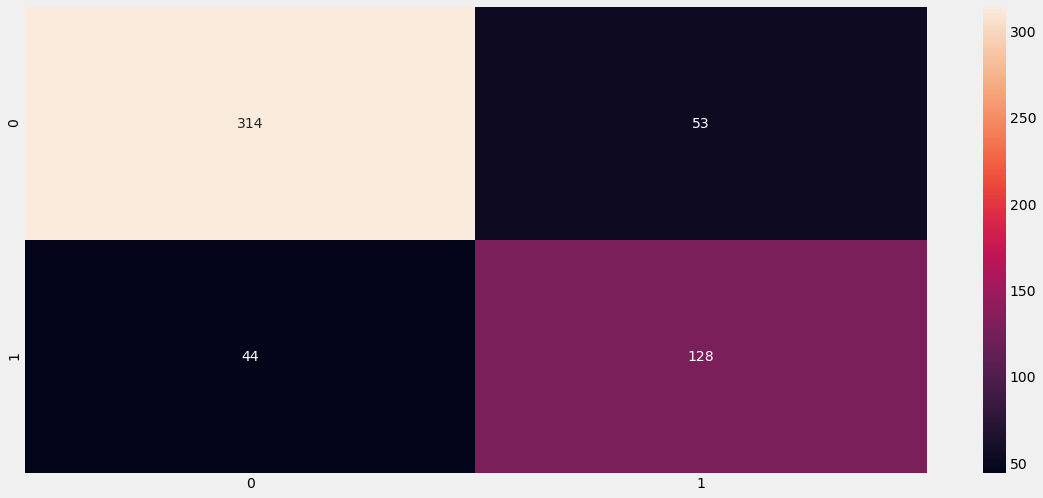

In [273]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f");

In [274]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       367
           1       0.71      0.74      0.73       172

    accuracy                           0.82       539
   macro avg       0.79      0.80      0.80       539
weighted avg       0.82      0.82      0.82       539



* This model not quite able to recognize reservation cancelled
* Maybe because of class imbalance, or dataset is to small
* Machine learning, especially Deep Learning is Data Hunger, they need to feed with a lot of data

## Final conclusion

Ada 2 jenis kesalahan yang mungkin terjadi dalam model ML di studi kasus ini, yaitu:

1. Model memprediksi user akan cancel booking (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan. - False Positive
1. Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user cancel booking (membatalkan pesanan) - False Negative

* Jenis kesalahan yang paling berpengaruh pada kerugian perusahaan adalah nomor 2 - False Negative
* Alasannya karena pihak hotel sudah menyiapkan banyak hal untuk menyambut kedatangan user seperti merapikan kamar, makanan minuman bahkan menolak pengunjung lain yang memesan kamar yang telah dipesan
* Tetapi akhirnya user tidak datang...